I was watching Society Game (a south korean game show) and in episode 3 of season 2 there was a challenge called Russian Janggi that involved playing this game:

![Society Game: Russian Janggi](https://i.imgur.com/RbGXPJ1.jpg)

The name of the game is Gobblet Gobblers, it's a lot like Tic-tac-toe.

![Gobblet Gobblers](https://i.imgur.com/GiOSQB2.jpg)

It's played on a 3×3 board, each player has 6 pieces: 2 small pieces, 2 midsized pieces and 2 big pieces. Much like Tic-tac-toe, the objective is to place 3 pieces of the player's color in a horizontal, vertical or diagonal row. Players take turns to place pieces on the board, but there are 2 twists:

Twist number 1: Bigger pieces can cover smaller pieces.

Twist number 2: The players can move their already placed pieces around in the board. But only in empty squares or when you can cover a smaller piece.

It's a surprisingly dynamic game and I want to investigate it with some coding.

# Data Structures

Let's start modelling the pieces:

In [1]:
from functools import partial

BIG_PIECE = 3
MID_PIECE = 2
SMALL_PIECE = 1

INITIAL_HAND = (BIG_PIECE, BIG_PIECE,
                MID_PIECE, MID_PIECE,
                SMALL_PIECE, SMALL_PIECE)

#from enum import IntEnum
#Piece = IntEnum('Piece', ['big', 'mid', 'small'])
#INITIAL_HAND = (Piece.big, Piece.big,
#                Piece.mid, Piece.mid,
#                Piece.small, Piece.small)

Like I described above, each player starts with 6 pieces in their hands. I'm using integers to represent the different sizes, it makes sense because I'll be checking if a piece is bigger than another to see if I can cover it or not.

As you can see in the commented code we could use IntEnum for this but eh I don't think it'd be worth it.

Next, let's do the board:

In [2]:
EMPTY_BOARD = ((), (), (),
               (), (), (),
               (), (), ())

Just a tuple of tuples, it's important to keep track of all the covered pieces in the board. This isn't the kind of thing that is readily apparent while playing the game, players have to remember the positions of the covered pieces. But it's still a game with perfect information after all.

In [3]:
def board_square(s):
    letter, number = s
    ret = 'abc'.index(letter) - (3*int(number)) + 9
    return ret

Here's a helper function to let us access the board coordinates this way:

| a3 | b3 | c3 |
|----|----|----|
| a2 | b2 | c2 |
| a1 | b1 | c1 |

Yes, it's supposed to be a lot like chess' algebraic notation.

In [4]:
def visible_pieces(board):
    ret = []
    for square in board:
        if len(square) == 0:
            ret.append(0)
            continue
        ret.append(square[-1])
    return tuple(ret)

This function will help us visualize the visible pieces in the board, and also will be important to let us know which pieces the players can move around.

There's an implicit condition here that the last piece in the square tuple should be the biggest piece, so uh... just to make sure let's make a function to assert this:

In [5]:
def validate_board(board):
    for square in board:
        assert square == tuple(sorted(square, key=abs))

Ok, we have hands and a board, this is enough to characterize the game state:

In [6]:
from collections import namedtuple

GameState = namedtuple('GameState', ['board', 'player_hand', 'opponent_hand'])

INITIAL_GAME_STATE = GameState(EMPTY_BOARD, INITIAL_HAND, INITIAL_HAND)

And by the way, I'll use negative integers to represent the opponent's pieces in the board, but I won't bother using negative numbers in the hands, they'll be always positive in them.

[//]: # "TODO(mcsalgado): I feel like changing the representation of the pieces because of this"

Let's validate a hand, there are only 3 kinds of pieces, and at most 6 in a hand. With that we can just wrap both validate functions into a function to validate an entire game state:

In [7]:
def validate_hand(hand):
    assert len(hand) <= 6
    assert len(set(hand)) <= 3
    for piece in hand:
        assert 0 < piece <= 3

def validate_game_state(state):
    board, player_hand, opponent_hand = state
    validate_board(board)
    validate_hand(player_hand)
    validate_hand(opponent_hand)

# Winning Game State

We got the board, pieces and hands so let's move to a very defining aspect of the game: The winning condition.

In [8]:
def is_won(visible_board):
    
    # NOTE(mcsalgado): horizontal win
    if (visible_board[0] > 0) and (visible_board[1] > 0) and (visible_board[2] > 0):
        return True
    if (visible_board[3] > 0) and (visible_board[4] > 0) and (visible_board[5] > 0):
        return True
    if (visible_board[6] > 0) and (visible_board[7] > 0) and (visible_board[8] > 0):
        return True
    
    # NOTE(mcsalgado): vertical win
    if (visible_board[0] > 0) and (visible_board[3] > 0) and (visible_board[6] > 0):
        return True
    if (visible_board[1] > 0) and (visible_board[4] > 0) and (visible_board[7] > 0):
        return True
    if (visible_board[2] > 0) and (visible_board[5] > 0) and (visible_board[8] > 0):
        return True

    # NOTE(mcsalgado): diagonal win
    if (visible_board[0] > 0) and (visible_board[4] > 0) and (visible_board[8] > 0):
        return True
    if (visible_board[2] > 0) and (visible_board[4] > 0) and (visible_board[6] > 0):
        return True

    return False

Pretty straightforward, no fancy stuff here. Notice that this function does not detect an opponent win. This is not gonna matter, you'll see why later.

Here's another function that is pretty much the same as the above but I'm returning the indices of the winning squares:

In [9]:
def winning_squares(visible_board):
    new_board = []
    for x in visible_board:
        if x > 0:
            new_board.append(1)
        elif x < 0:
            new_board.append(-1)
        else:
            new_board.append(0)
    
    # NOTE(mcsalgado): horizontal win
    if visible_board[0] and (new_board[0] == new_board[1] == new_board[2]):
        return (0, 1, 2)
    if visible_board[3] and (new_board[3] == new_board[4] == new_board[5]):
        return (3, 4, 5)
    if visible_board[6] and (new_board[6] == new_board[7] == new_board[8]):
        return (6, 7, 8)
    
    # NOTE(mcsalgado): vertical win
    if visible_board[0] and (new_board[0] == new_board[3] == new_board[6]):
        return (0, 3, 6)
    if visible_board[1] and (new_board[1] == new_board[4] == new_board[7]):
        return (1, 4, 7)
    if visible_board[2] and (new_board[2] == new_board[5] == new_board[8]):
        return (2, 5, 8)

    # NOTE(mcsalgado): diagonal win
    if visible_board[0] and (new_board[0] == new_board[4] == new_board[8]):
        return (0, 4, 8)
    if visible_board[2] and (new_board[2] == new_board[4] == new_board[6]):
        return (2, 4, 6)

    return None

# Visualization

So now what about a few functions to visualize the game state here in this jupyter notebook:

(I'm so sorry for my code here, I'm not exactly the most pragmatic person when it comes to HTML...)

In [10]:
from IPython.core.display import display, HTML

PIECE_HTML_SNIPPET = {-SMALL_PIECE: 'color: #ef541c; font-size: 0.7em; padding: 0;">⚫',
                      -MID_PIECE: 'color: #ef541c; font-size: 1.75em; padding: 0;">⚫',
                      -BIG_PIECE: 'color: #ef541c; font-size: 3.75em; padding: 0">⚫',
                      SMALL_PIECE: 'color: #04a317; font-size: 0.7em; padding: 0;">⚫',
                      MID_PIECE: 'color: #04a317; font-size: 1.75em; padding: 0;">⚫',
                      BIG_PIECE: 'color: #04a317; font-size: 3.75em; padding: 0">⚫'}

def html_board(visible_board, winning_squares=None):
    code = '<table><tbody>'
    for i, piece in enumerate(visible_board):    
        if (i == 0) or (i % 3 == 0):
            code += f'<tr><td style="vertical-align: middle">{3-(i//3)}</td>'
            
        piece_snippet = PIECE_HTML_SNIPPET.get(piece, '">')
        code += '<td style="border: 1px solid black; text-align: center; vertical-align: middle; width:70px; height: 70px; '
        if winning_squares and (i in winning_squares):
            code += 'background-color: #efe145; '
        else:
            code += 'background-color: #d8d8d8; '
        code += f'{piece_snippet}</td>'

        if (i == 2) or (i % 3 == 2):
            code += '</tr>'
    
    code += '<tr><td></td><td style="text-align: center">a</td><td style="text-align: center">b</td><td style="text-align: center">c</td></tr></tbody></table>'

    return code

def html_hand(hand, is_opponent=False):
    code = ''
    for piece in hand:
        if is_opponent:
            piece *= -1
        piece_snippet = PIECE_HTML_SNIPPET[piece]
        code += '<span style="padding:10px; ' + piece_snippet + '</span>'
    return code

def display_game_state(state):
    visible_board = visible_pieces(state.board)
    display(HTML(html_hand(state.opponent_hand, is_opponent=True) + '<br>' +
                 html_board(visible_board, winning_squares(visible_board)) + '<br>' +
                 html_hand(state.player_hand)))

Now I can show an entire match that happened in the episode (around 40:10), we'll use it as reference:

In [11]:
REFERENCE_MATCH = (INITIAL_GAME_STATE,
                   GameState(((), (), (),
                              (), (3, ), (),
                              (), (), ()), (3, 2, 2, 1, 1), INITIAL_HAND),
                   GameState(((), (), (),
                              (), (3, ), (),
                              (), (), (-3, )), (3, 2, 2, 1, 1), (3, 2, 2, 1, 1)),
                   GameState(((), (), (),
                              (), (3, ), (),
                              (3, ), (), (-3, )), (2, 2, 1, 1), (3, 2, 2, 1, 1)),
                   GameState(((), (), (-2, ),
                              (), (3, ), (),
                              (3, ), (), (-3, )), (2, 2, 1, 1), (3, 2, 1, 1)),
                   GameState(((), (), (-2, 3),
                              (), (3, ), (),
                              (), (), (-3, )), (2, 2, 1, 1), (3, 2, 1, 1)),
                   GameState(((), (), (-2, 3),
                              (), (3, ), (),
                              (-2, ), (), (-3, )), (2, 2, 1, 1), (3, 1, 1)),
                   GameState(((), (), (-2, 3),
                              (), (), (),
                              (-2, 3), (), (-3, )), (2, 2, 1, 1), (3, 1, 1)),
                   GameState(((), (), (-2, 3),
                              (), (-3,), (),
                              (-2, 3), (), (-3, )), (2, 2, 1, 1), (1, 1)),
                   GameState(((2,), (), (-2, 3),
                              (), (-3,), (),
                              (-2, 3), (), (-3, )), (2, 1, 1), (1, 1)),
                   GameState(((2, -3), (), (-2, 3),
                              (), (-3,), (),
                              (-2, 3), (), ()), (2, 1, 1), (1, 1)),
                   GameState(((2, -3), (), (-2, 3),
                              (), (-3,), (),
                              (-2, 3), (), (2, )), (1, 1), (1, 1)),
                   GameState(((2, -3), (), (-2, 3),
                              (), (-3,), (-1, ),
                              (-2, 3), (), (2, )), (1, 1), (1,)),
                   GameState(((2, -3), (), (-2, 3),
                              (), (-3,), (-1, ),
                              (-2, 3), (1, ), (2, )), (1,), (1,)),
                  )

def display_match(match):
    for i, state in enumerate(match):
        print(f'Move {i}')
        display_game_state(state)
        print('========================================')

display_match(REFERENCE_MATCH)

Move 0


Move 1


Move 2


Move 3


Move 4


Move 5


Move 6


Move 7


Move 8


Move 9


Move 10


Move 11


Move 12


Move 13


We know that in the reference match only the last move is a winning state for the first player, so let's use this fact to test `is_won`.

In [12]:
def test_is_won():
    for state in REFERENCE_MATCH[:-1]:
        assert False == is_won(visible_pieces(state.board))

    assert True == is_won(visible_pieces(REFERENCE_MATCH[-1].board))

test_is_won()

# Player Moves

To be sure at this point we're in the same page let's review the concepts defined:

- **piece**: an integer ranging from 1 to 3 representing the piece size. A negative integer represents a piece belonging to the opponent.

- **square**: a tuple where the players can place pieces in the game, pieces can stack and cover smaller ones.

- **board**: a 3x3 tuple of squares.

- **hand**: a tuple of starting pieces that each player has and can place in a square.

- **game state**: a tuple of a board and the players' hands.

- **match**: a tuple of game states.

Now to finish coding the movement of pieces, let's define 2 functions. The first one pops the biggest piece from a given square position. The second one places a piece on the board.

In [13]:
def pop_piece(board, pos):
    popped_piece = board[pos][-1]
    new_board = board[:pos] + (board[pos][:-1], ) + board[pos+1:]
    return new_board, popped_piece

def place_piece(board, pos, piece):
    new_board = board[:pos] + (board[pos] + (piece, ), ) + board[pos+1:]
    return new_board

I'm sticking to a functional style here, instead of mutating the board I'm creating new ones. This explains why I chose to represent the board as tuples.

Oh wait, I forgot about taking a piece out of the hand:

In [14]:
def remove_piece(hand, piece):
    hand_index_piece = hand.index(piece)
    new_hand = hand[:hand_index_piece] + hand[hand_index_piece+1:]
    return new_hand

Actually, we can wrap these 3 functions into 2 functions that model the possible player movements given a game state:

In [15]:
def drop_move(state, piece, dest_square_pos):
    board, player_hand, opponent_hand = state
    player_hand = remove_piece(player_hand, piece)
    board = place_piece(board, dest_square_pos, piece)
    ret = GameState(board, player_hand, opponent_hand)
    return ret

def board_move(state, origin_square_pos, dest_square_pos):
    board, player_hand, opponent_hand = state
    board, popped_piece = pop_piece(board, origin_square_pos)
    board = place_piece(board, dest_square_pos, popped_piece)
    ret = GameState(board, player_hand, opponent_hand)
    return ret

Now I'll try to express the reference match with these functions, but before that I'll employ this trick:

In [16]:
def flip(state):
    new_board = []
    for cell in state.board:
        new_board.append(tuple(-x for x in cell))

    return GameState(tuple(new_board),
                     state.opponent_hand,
                     state.player_hand)

You see, I don't need to write any special code for the opponents' movements because I'll just flip the game state to make the opponent be the current player and vice-versa! This may sound a little bit roundabout now but it's a key insight of the negamax algorithm as we'll see later.

So now we can test the players' movements reproducing the reference match.

In [17]:
def test_player_movements():
    match = []
    
    # NOTE(mcsalgado): Move 0
    state = INITIAL_GAME_STATE
    validate_game_state(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 1
    state = drop_move(state, BIG_PIECE, board_square('b2'))
    validate_game_state(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 2
    state = flip(state)
    state = drop_move(state, BIG_PIECE, board_square('c1'))
    validate_game_state(state)
    state = flip(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 3
    state = drop_move(state, BIG_PIECE, board_square('a1'))
    validate_game_state(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 4
    state = flip(state)
    state = drop_move(state, MID_PIECE, board_square('c3'))
    validate_game_state(state)
    state = flip(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 5
    state = board_move(state, board_square('a1'), board_square('c3'))
    validate_game_state(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 6
    state = flip(state)
    state = drop_move(state, MID_PIECE, board_square('a1'))
    validate_game_state(state)
    state = flip(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 7
    state = board_move(state, board_square('b2'), board_square('a1'))
    validate_game_state(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 8
    state = flip(state)
    state = drop_move(state, BIG_PIECE, board_square('b2'))
    validate_game_state(state)
    state = flip(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 9
    state = drop_move(state, MID_PIECE, board_square('a3'))
    validate_game_state(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 10
    state = flip(state)
    state = board_move(state, board_square('c1'), board_square('a3'))
    validate_game_state(state)
    state = flip(state)
    match.append(state)

    # NOTE(mcsalgado): Move 11
    state = drop_move(state, MID_PIECE, board_square('c1'))
    validate_game_state(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 12
    state = flip(state)
    state = drop_move(state, SMALL_PIECE, board_square('c2'))
    validate_game_state(state)
    state = flip(state)
    match.append(state)
    
    # NOTE(mcsalgado): Move 13
    state = drop_move(state, SMALL_PIECE, board_square('b1'))
    validate_game_state(state)
    match.append(state)
    
    assert len(REFERENCE_MATCH) == len(match)
    for state, state_reference in zip(match, REFERENCE_MATCH):
        assert state_reference == state
        
test_player_movements()

This took some work but hey we're slowly building a pretty decent test suite.

# Quick Aside: Algebraic-like Notation

Let's go beyond and write a simple parser for an algebraic-like notation for the game. We'll be able to represent the reference match with just this:

In [18]:
REFERENCE_MATCH_STRING = ('1. 3b2 3c1 '
                          '2. 3a1 2c3 '
                          '3. a1c3 2a1 '
                          '4. b2a1 3b2 '
                          '5. 2a3 c1a3 '
                          '6. 2c1 1c2 '
                          '7. 1b1#')

Hand moves are denoted as a piece size and a square, board moves are denoted as 2 squares.

In [19]:
import re

MOVE_REGEX = re.compile(r'(?:([123])|([abc][123]))([abc][123])#?')
LINE_REGEX = re.compile(r'\d. ([123abc#]+(?: [123abc#]+)?)')

def parse_move(move_string):
    hand_piece, origin, dest = MOVE_REGEX.findall(move_string)[0]
    if hand_piece:
        ret = lambda state: drop_move(state, int(hand_piece), board_square(dest))
        return ret
    if origin:
        ret = lambda state: board_move(state, board_square(origin), board_square(dest))
        return ret
    
def parse(match_string):
    match = [INITIAL_GAME_STATE]
    for line in LINE_REGEX.findall(match_string):
        if not line:
            continue

        moves = line.split()
        assert 0 < len(moves) <= 2

        last_state = match[-1]
        new_state = parse_move(moves[0])(last_state)
        match.append(new_state)
        
        if len(moves) == 2:
            last_state = flip(new_state)
            new_state = parse_move(moves[1])(last_state)
            new_state = flip(new_state)
            match.append(new_state)
    return match

In [20]:
def test_parse():
    parsed_reference_match_string = parse(REFERENCE_MATCH_STRING)
    assert len(parsed_reference_match_string) == len(REFERENCE_MATCH)
    for parsed_state, reference_state in zip(parsed_reference_match_string, REFERENCE_MATCH):
        assert parsed_state == reference_state

test_parse()

# Finishing up Moves

Back to business, with the board that a player is seeing, let's return the board position and the piece that the player can move:

In [21]:
def movable_pieces_positions(visible_board):
    ret = set()
    for pos, topmost_piece in enumerate(visible_board):
        if topmost_piece == 0:
            continue
        
        if topmost_piece > 0:
            ret.add((pos, topmost_piece))
    return ret

Now let's write one of the most important functions for this notebook. Given a game state, we generate all the possible successor states resulting from moves that a player can make:

In [22]:
def legal_moves(state):
    board, player_hand, opponent_hand = state
    visible_board = visible_pieces(board)
    
    ret = set()
    
    # NOTE(mcsalgado): drop moves
    for piece in set(player_hand):
        for pos, dest_piece in enumerate(visible_board):
            if piece > abs(dest_piece):
                new_state = drop_move(state, piece, pos)
                ret.add(new_state)

    # NOTE(mcsalgado): board moves
    for origin_square_pos, piece in movable_pieces_positions(visible_board):
        for dest_square_pos, dest_piece in enumerate(visible_board):
            if dest_square_pos == origin_square_pos:
                continue
            new_board, popped_piece = pop_piece(board, origin_square_pos)

            if popped_piece > abs(dest_piece):
                new_state = GameState(place_piece(new_board, dest_square_pos, popped_piece),
                                      player_hand,
                                      opponent_hand)
                ret.add(new_state)
    return ret

def test_legal_moves():
    assert 28 == len(legal_moves(REFERENCE_MATCH[2]))

I could not use the `board_move` function here because I needed to check if that drop would be legal in the middle of the process.

And yes, I know I'm mixing up the notion of a move and a state... It doesn't matter much here in what we're doing.

In [23]:
def number_of_legal_moves_in_a_match(match):
    ret = []
    for state in match:
        ret.append(len(legal_moves(state)))

    return ret

def test_number_of_legal_moves_in_a_match():
    assert number_of_legal_moves_in_a_match(REFERENCE_MATCH) == [27, 32, 28, 24, 22, 24, 22, 24, 20, 22, 20, 18, 17, 18]

test_number_of_legal_moves_in_a_match()

I didn't think I was going to do any plotting in this notebook but you know how it is, I stumbled upon this sequence and... it called me.

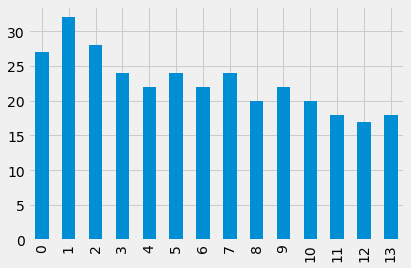

In [24]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use(['fivethirtyeight'])

def plot_number_of_legal_moves_in_a_match(match):
    df = pd.DataFrame()
    df[0] = pd.Series(number_of_legal_moves_in_a_match(match))
    ax = df.plot(kind='bar', legend=None)

plot_number_of_legal_moves_in_a_match(REFERENCE_MATCH)

This gives us a nice intuition of how the branching factor in Gobblet Gobblers.

# Player Agents

We can start studying the game with what we have now! Let's define a player agent that picks randomly from a set of possible moves.

In [25]:
import random

def random_player(state):
    ret = random.choice(list(legal_moves(state)))
    return ret

And now an actual function that takes 2 player agents and play a game match.

In [26]:
def play_match(player1, player2):
    match = []
    state = GameState(EMPTY_BOARD, INITIAL_HAND, INITIAL_HAND)
    match.append(state)
    for i in range(100):
        state = player1(state)
        match.append(state)
        flipped_state = flip(state)
        
        if is_won(visible_pieces(flipped_state.board)):
            first_player_won = False
            return match, first_player_won
        if is_won(visible_pieces(state.board)):
            first_player_won = True
            return match, first_player_won
        state = flipped_state
        
        state = player2(state)
        flipped_state = flip(state)
        match.append(flipped_state)
        
        if is_won(visible_pieces(flipped_state.board)):
            first_player_won = True
            return match, first_player_won
        if is_won(visible_pieces(state.board)):
            first_player_won = False
            return match, first_player_won
        state = flipped_state

    return None

The `play_match` function does not validate the states given by the players in any way, so gotta be careful with this here... I'll be optimistic that every player agent only generates valid moves.

This is probably one of the most subtle functions in this notebook...

First: Gobblet Gobblers is unlike Tic-tac-toe in another aspect: The players can loop through the same moves and play forever! To prevent this I set a hard limit of 100 moves in a game.

Second: This may or may not be a rule that I just made up, I'm not sure, I must look up the official rules! Anyway there are certain board positions like this one:

In [27]:
PROBLEMATIC_STATE = flip(GameState(board=((2,), (), (1,), (3,), (3,), (-2,), (2, -3), (), (-3,)), player_hand=(1,), opponent_hand=(2, 1, 1)))

display_game_state(PROBLEMATIC_STATE)

If the player does a1c3 here...

In [28]:
display_game_state(parse_move('a1c3')(PROBLEMATIC_STATE))

...it discovers an opponent piece at a1 and loses the game! Even if movement made a row with their own pieces.

So it's important to check if the opponent won *before* the player won.

Time to watch this yacht boy play with itself:

In [29]:
random_players_match, _ = play_match(random_player, random_player)
display_match(random_players_match)

Move 0


Move 1


Move 2


Move 3


Move 4


Move 5


Move 6


Move 7


Move 8


Move 9


Move 10


Move 11


Move 12


Move 13


Move 14


Move 15


Move 16


Move 17


Move 18


Not exactly a battle of giants here. Let's graph again the number of legal moves at each turn.

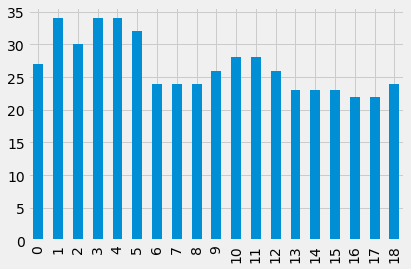

In [30]:
plot_number_of_legal_moves_in_a_match(random_players_match)

If you're not running this Jupyter notebook then oh man, you'll miss this one out... I wrote some functions here so you can actually play the game against `random_player`! Run these 2 cells:

In [ ]:
def user_input_player(state):
    legal_moves_state = legal_moves(state)
    while True:
        move_input = input('Type your move: ')
        try:
            ret = parse_move(move_input)(state)
            if ret in legal_moves_state:
                break
        except:
            pass
        print('Illegal move')
    return ret

def player_display_moves(player, state):
    ret = player(state)
    display_game_state(ret)
    print('========================================')
    return ret

def opponent_display_moves(player, state):
    ret = player(state)
    display_game_state(flip(ret))
    print('========================================')
    return ret

In [ ]:
display_game_state(INITIAL_GAME_STATE)
user_vs_random_match, user_vs_random_match_result = play_match(partial(player_display_moves, user_input_player),
                                                               partial(opponent_display_moves, random_player))
if user_vs_random_match_result:
    print('Congrats! You won!')
else:
    print('You lost to random, shame on you.')

Remember the input format is like we defined in the algebraic-like notation section: 3a1 to drop a big piece from your hand to the a1 square, b1c3 moves a piece from b1 to c3.

# Monte Carlo simulations

Let's get crazy and simulate a thousand matches of `random_player` against itself and plot a bunch of graphs.

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of <function random_player at 0x00000079AA341A60> vs <function random_player at 0x00000079AA341A60>
55.9% of first player (<function random_player at 0x00000079AA341A60>) victories.

Match length statistics:
count    1000.000000
mean       13.689000
std         4.897373
min         6.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        37.000000
dtype: float64



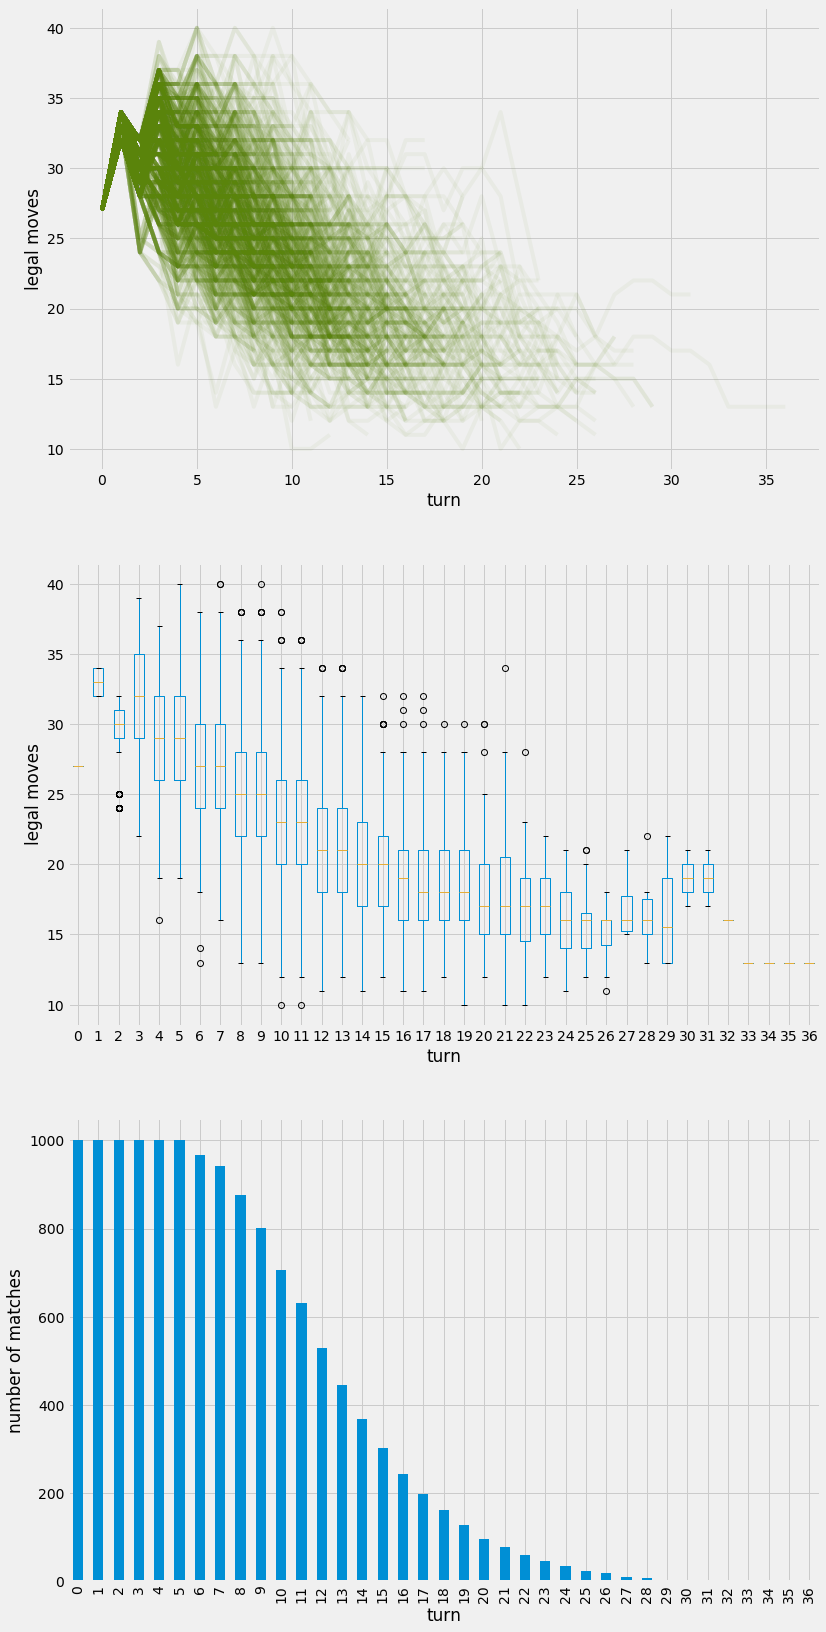

In [31]:
from statistics import mean

def simulate_matches(n, player1, player2):
    matches = []
    first_player_won_data = []
    for i in range(n):
        if i % (n//10) == 0:
            print(i, 'matches played...')
        result = play_match(player1, player2)
        if result:
            match, first_player_won = result
            matches.append(match)
            first_player_won_data.append(first_player_won)
    
    print()
    print(f'Simulated {n} matches of {player1} vs {player2}')
    average_win_percentage = mean(first_player_won_data)*100
    print(f'{average_win_percentage:.1f}% of first player ({player1}) victories.')
    print()
    
    max_match_length = max(map(len, matches))

    df = pd.DataFrame(pd.np.empty((max_match_length, 1)))
    for i, match in enumerate(matches):
        df[i] = pd.Series(number_of_legal_moves_in_a_match(match))
    
    print('Match length statistics:')
    print(df.count().describe())
    print()
    
    fig, axes = plt.subplots(nrows=3)
    figsize = [12, 9*3]

    p1 = df.plot(legend=None, alpha=.05, c='#5a840b', figsize=figsize, ax=axes[0])
    p1.set_ylabel("legal moves")
    p1.set_xlabel("turn")
    
    p2 = df.transpose().boxplot(ax=axes[1], figsize=figsize)
    p2.set_ylabel("legal moves")
    p2.set_xlabel("turn")
    
    p3 = df.transpose().count().plot(legend=None, kind='bar', color='C0', ax=axes[2], figsize=figsize)
    p3.set_ylabel("number of matches")
    p3.set_xlabel("turn")


simulate_matches(1000, random_player, random_player)

The first player wins more often but by a relatively close margin.

# Negamax

The negamax algorithm is a special case of the minimax algorithm for zero-sum games. I recommend actually watching a video explaining how this algorithm works but in technical terms it's just a depth first search via recursion.

The marked line is the one that you should be carefully studying. It flips the board and negates the score, so now the opponent will be actually minimizing the score from the player's point of view. And it keeps alternating through the recursion calls, it's brilliant.

In [32]:
def negamax(depth, state):
    if state in negamax.cache:
        cached_score, cached_depth = negamax.cache[state]
        if (cached_score != 0) or (depth <= cached_depth):
            return cached_score

    # NOTE(mcsalgado): important to check if opponent won first!
    if is_won(visible_pieces(flip(state).board)):
        return -1

    if is_won(visible_pieces(state.board)):
        return 1
    
    if depth == 0:
        return 0

    ret = -0xbeef
    for legal_move in legal_moves(state):
        score = -negamax(depth-1, flip(legal_move)) # 👈👈👈👈 🔥
        ret = max(ret, score)
        if score == -1:
            continue
        negamax.cache[state] = (score, depth)
        negamax.cache[legal_move] = (score, depth-1)
        if ret == 1:
            return ret

    return ret

negamax.cache = {}

By the way, I included a memoization cache inside a function attribute here, it'll help a lot with speed performance.

In [33]:
def test_negamax():
    assert 1 == negamax(1, GameState(board=((-2,), (-2,), (3,), (), (-3,), (), (1, -3), (), (3,)),
                                     player_hand=(2, 2, 1),
                                     opponent_hand=(1, 1)))
    assert 1 == negamax(2, GameState(board=((-2,), (-2,), (3,), (), (-3,), (), (1, -3), (), (3,)),
                                     player_hand=(2, 2, 1),
                                     opponent_hand=(1, 1)))

test_negamax()

Some super weak sauce testing but hey better than nothing!

In [34]:
negamax.cache

{GameState(board=((-2,), (-2,), (3,), (), (-3,), (), (1, -3), (), (3,)), player_hand=(2, 2, 1), opponent_hand=(1, 1)): (1,
  1),
 GameState(board=((-2,), (-2,), (3,), (), (-3,), (2,), (1, -3), (), (3,)), player_hand=(2, 1), opponent_hand=(1, 1)): (1,
  0),
 GameState(board=((-2,), (-2,), (3,), (2,), (-3,), (), (1, -3), (), (3,)), player_hand=(2, 1), opponent_hand=(1, 1)): (0,
  0)}

See? I hope this gives you a feel of how memoization is working here.

We can use negamax to analyze a match, I'll do it from the end to the beginning (because the last moves are less complex than the first ones) and gradually increase the depth as necessary. This is an example of iterative deepening depth-first search.

In [35]:
def analyze(algorithm, match, max_depth):
    depth = 1
    for i, state in list(reversed(list(enumerate(match))))[1:]:
        print(f'Move {i}')
        display_game_state(state)
    
        if i % 2 != 0:
            state = flip(state)
    
        while True:
            score = algorithm(depth, state)
            if score == 1:
                if i % 2 == 0:
                    print('winning position for green')
                else:
                    print('losing position for green')
                break
            if score == -1:
                if i % 2 == 0:
                    print('losing position for green')
                else:
                    print('winning position for green')
                break
            if score == 0:
                print(f"can't evaluate with depth {depth}")
                if depth == max_depth:
                    break
                depth += 1
            
        print('========================================')
        if score == 0:
            return

We can use this to investigate the reference match.

In [36]:
%%time
analyze(negamax, REFERENCE_MATCH, 6)

Move 12


winning position for green
Move 11


can't evaluate with depth 1
winning position for green
Move 10


can't evaluate with depth 2
winning position for green
Move 9


winning position for green
Move 8


winning position for green
Move 7


can't evaluate with depth 3
can't evaluate with depth 4
winning position for green
Move 6


winning position for green
Move 5


can't evaluate with depth 5
can't evaluate with depth 6
Wall time: 16 s


Well, the game tree for Gobblet Gobblers is pretty big so going beyond depth 6 is tough for now. This is a wall that you hit with most games when you use negamax, just memoizing the moves is usually not enough.

# Quick Aside: Alpha-Beta Pruning

A quick way to improve minimax-like algorithms is with alpha beta pruning, so here, let's do this!

In [37]:
def negamax_αβ(depth, α, β, state):
    if state in negamax_αβ.cache:
        cached_score, cached_depth = negamax_αβ.cache[state]
        if (cached_score != 0) or (depth <= cached_depth):
            return cached_score

    if is_won(visible_pieces(flip(state).board)):
        return -1
    if is_won(visible_pieces(state.board)):
        return 1
    if depth == 0:
        return 0

    ret = -0xbeef
    for legal_move in legal_moves(state):
        score = -negamax_αβ(depth-1, -β, -α, flip(legal_move))
        ret = max(ret, score)
        α = max(α, score)
        if α >= β:
            negamax_αβ.cache[state] = (ret, depth)
            return ret
        if ret == -1:
            continue
        negamax_αβ.cache[state] = (ret, depth)
        if ret == 1:
            return ret

    return ret

negamax_αβ.cache = {}

I hope you appreciated that I used the actual greek letters here lol.

So now... Let's analyze the reference game again. This time we can go deeper.

In [38]:
%%time
analyze(lambda depth, state: negamax_αβ(depth, -0xbeef, 0xbeef, state), REFERENCE_MATCH, 7)

Move 12


winning position for green
Move 11


can't evaluate with depth 1
winning position for green
Move 10


can't evaluate with depth 2
winning position for green
Move 9


winning position for green
Move 8


winning position for green
Move 7


can't evaluate with depth 3
winning position for green
Move 6


can't evaluate with depth 4
winning position for green
Move 5


can't evaluate with depth 5
winning position for green
Move 4


can't evaluate with depth 6
winning position for green
Move 3


winning position for green
Move 2


winning position for green
Move 1


can't evaluate with depth 7
Wall time: 52.6 s


As you can see the initial positions are still tough to tackle...

But apparently green made no mistakes according to negamax.

# More Player Agents

Instead of just using negamax to evaluate positions, let's get a better feel of how negamax *actually* plays... The next natural step is a player agent!

In [39]:
def negamax_player(depth, state):
    best_score = -0xbeef
    candidates = []
    for legal_move in legal_moves(state):
        score = -negamax_αβ(depth, -0xbeef, 0xbeef, flip(legal_move))
        if score == 1:
            return legal_move
        if score > best_score:
            best_score = score
            candidates = [legal_move]
        elif score == best_score:
            candidates.append(legal_move)

    ret = random.choice(candidates)
    return ret

def talkative_negamax_player(depth, state):
    best_score = -0xbeef
    legal_moves_state = legal_moves(state)
    print(f"<negamax> I have {len(legal_moves_state)} positions to negamax... 💪")
    candidates = []
    for legal_move in legal_moves_state:
        score = -negamax_αβ(depth, -0xbeef, 0xbeef, flip(legal_move))
        #print(legal_move, score)
        if score == 1:
            print("<negamax> I got a move, I'm going to win! 😊")
        if score > best_score:
            best_score = score
            candidates = [legal_move]
        elif score == best_score:
            candidates.append(legal_move)
    if best_score == 0:
        print("<negamax> This game... I'm not sure how it'll go but I'm trying my best 😤")
    elif best_score == -1:
        print("<negamax> I'm going to lose. 😞")
    ret = random.choice(candidates)
    return ret

The `negamax player` has a random element to it, this makes them more interesting to play against and also it'll be important for more Monte Carlo simulations later.

So again, time to play it! I guarantee this time it'll be way more interesting than `random_player`...

In [ ]:
display_game_state(INITIAL_GAME_STATE)
user_vs_negamax_match, user_vs_negamax_match_result = play_match(partial(player_display_moves, user_input_player),
                                                                 partial(opponent_display_moves, 
                                                                         partial(talkative_negamax_player, 3)))
if user_vs_negamax_match_result:
    print('Congrats! You won! Wow!')
else:
    print("You lost to negamax, that's alright.")

In [ ]:
analyze(lambda depth, state: negamax_αβ(depth, -0xbeef, 0xbeef, state), user_vs_negamax_match, 7)

You may have noticed that `negamax_player` wastes a lot of time with the first moves.

But let me describe negamax's biggest weakness as a player: if minimax knows it'll lose then it'll just kind of give up and play whatever instead of trying to extend the game to fish out blunders from you. And when it knows it'll win sometimes it starts playing around and instead of getting an obvious and direct win sometimes it'll make roundabout moves (but still winning) instead.

In [40]:
len(negamax_αβ.cache)

312857

Ok, it seems like we filled quite a bit of cache for minimax.

# Monte Carlo simulations with Minimax

We got the power of `minimax_player` on our side now, it can't just solve the entire game but... Let's first compare it against `random_player`.

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of <function random_player at 0x00000079AA341A60> vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
3.6% of first player (<function random_player at 0x00000079AA341A60>) victories.

Match length statistics:
count    1000.000000
mean        9.153000
std         2.479463
min         6.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        21.000000
dtype: float64

Wall time: 23.4 s


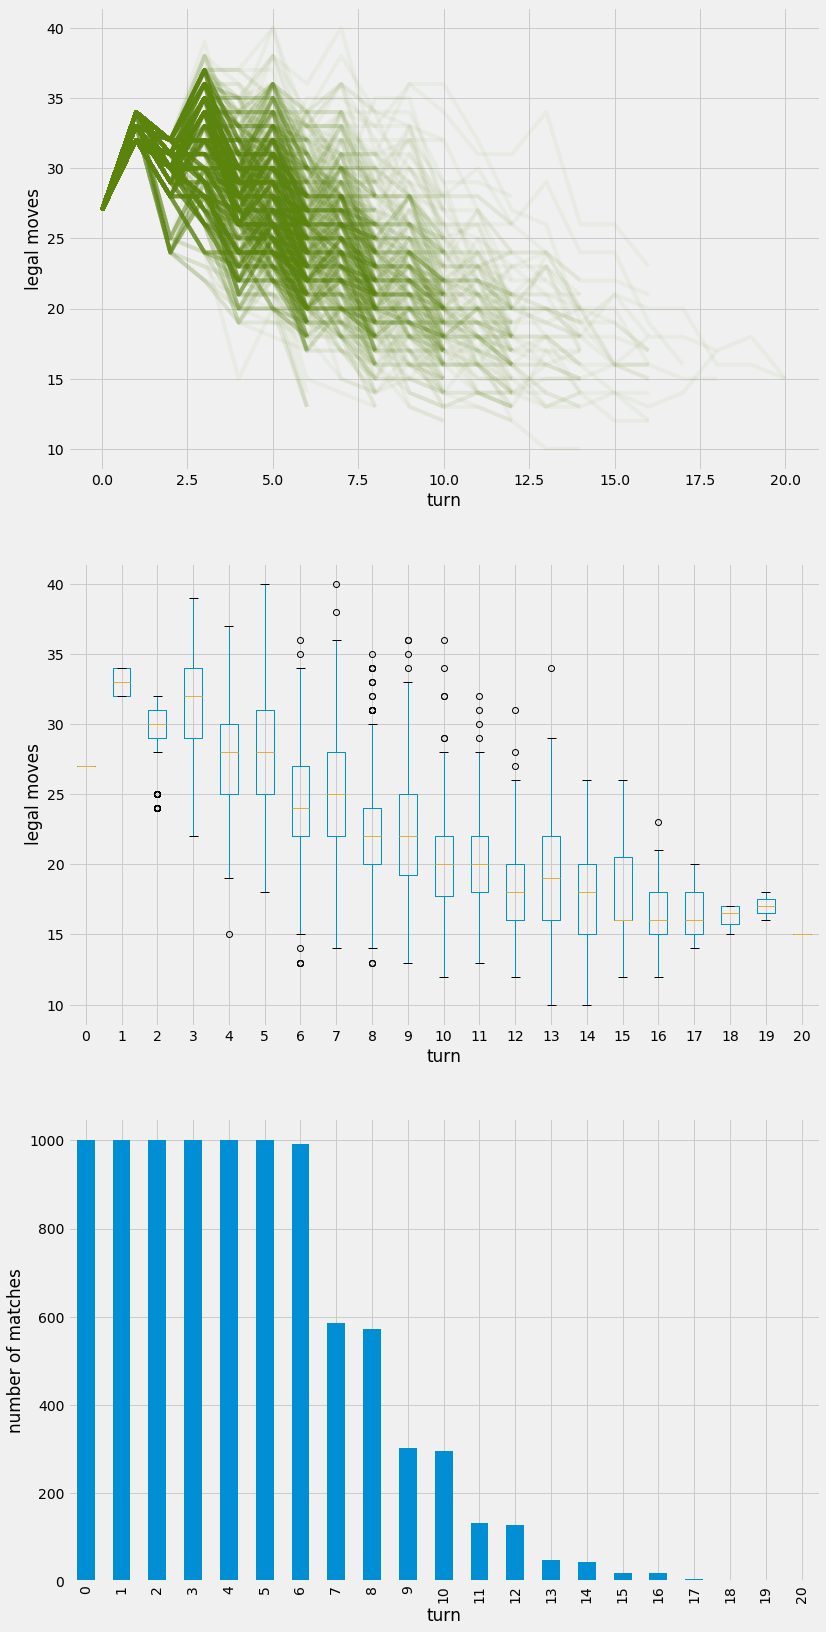

In [41]:
%%time
simulate_matches(1000, random_player, partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1) vs <function random_player at 0x00000079AA341A60>
98.1% of first player (functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) victories.

Match length statistics:
count    1000.000000
mean        8.223000
std         2.470096
min         6.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        21.000000
dtype: float64

Wall time: 16.9 s


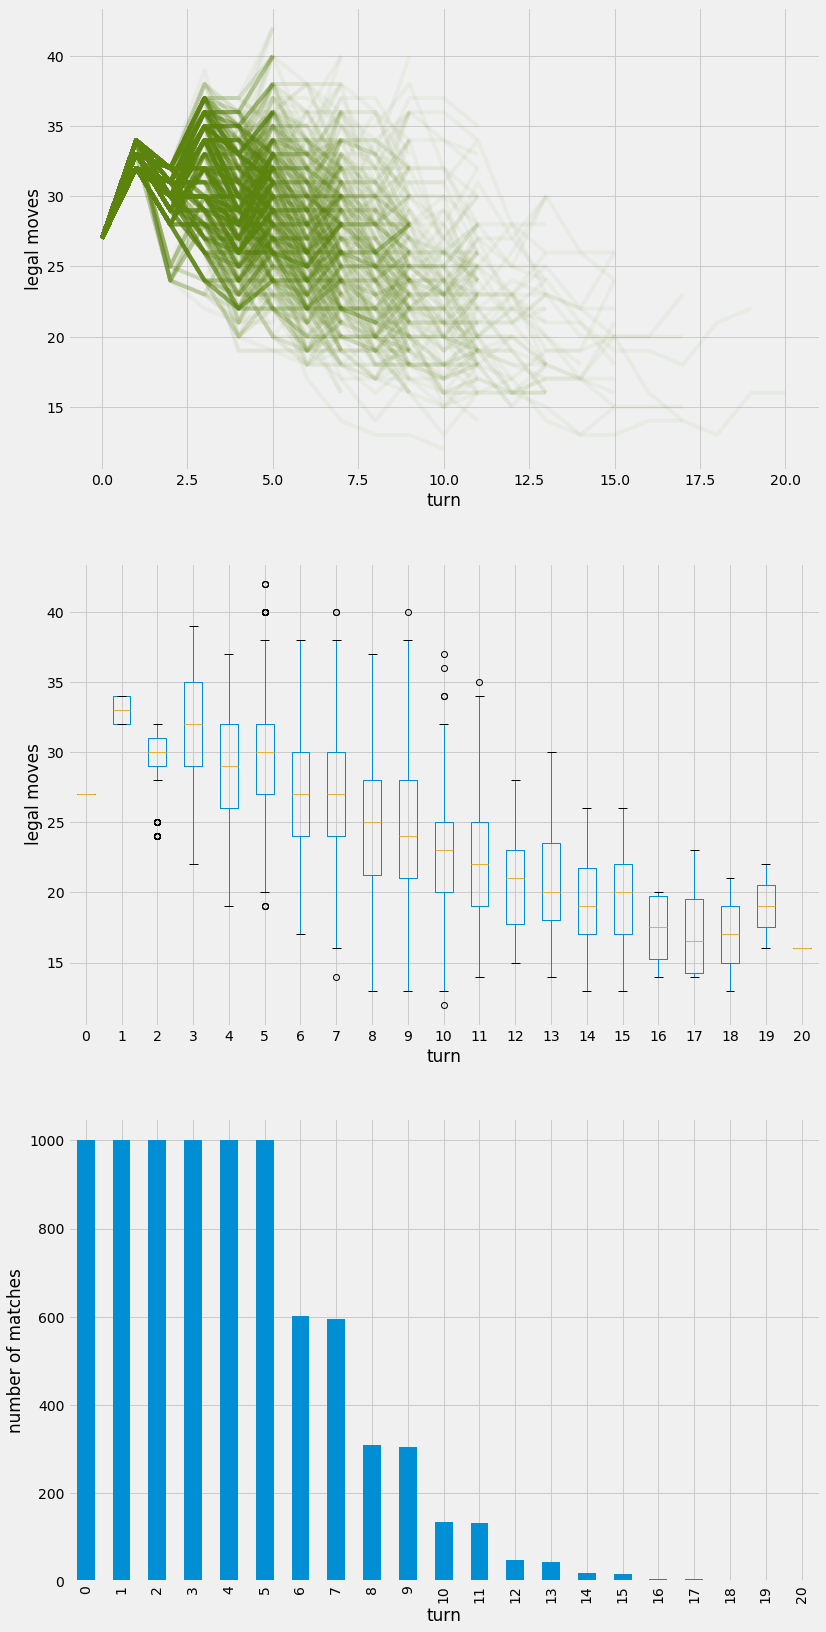

In [42]:
%%time
simulate_matches(1000, partial(negamax_player, 1), random_player)

Even at a shallow depth, `negamax_player` is a considerably better reference for sure.

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
56.6% of first player (functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) victories.

Match length statistics:
count    999.000000
mean      12.311311
std        4.904722
min        6.000000
25%        8.000000
50%       12.000000
75%       16.000000
max       36.000000
dtype: float64

Wall time: 50.5 s


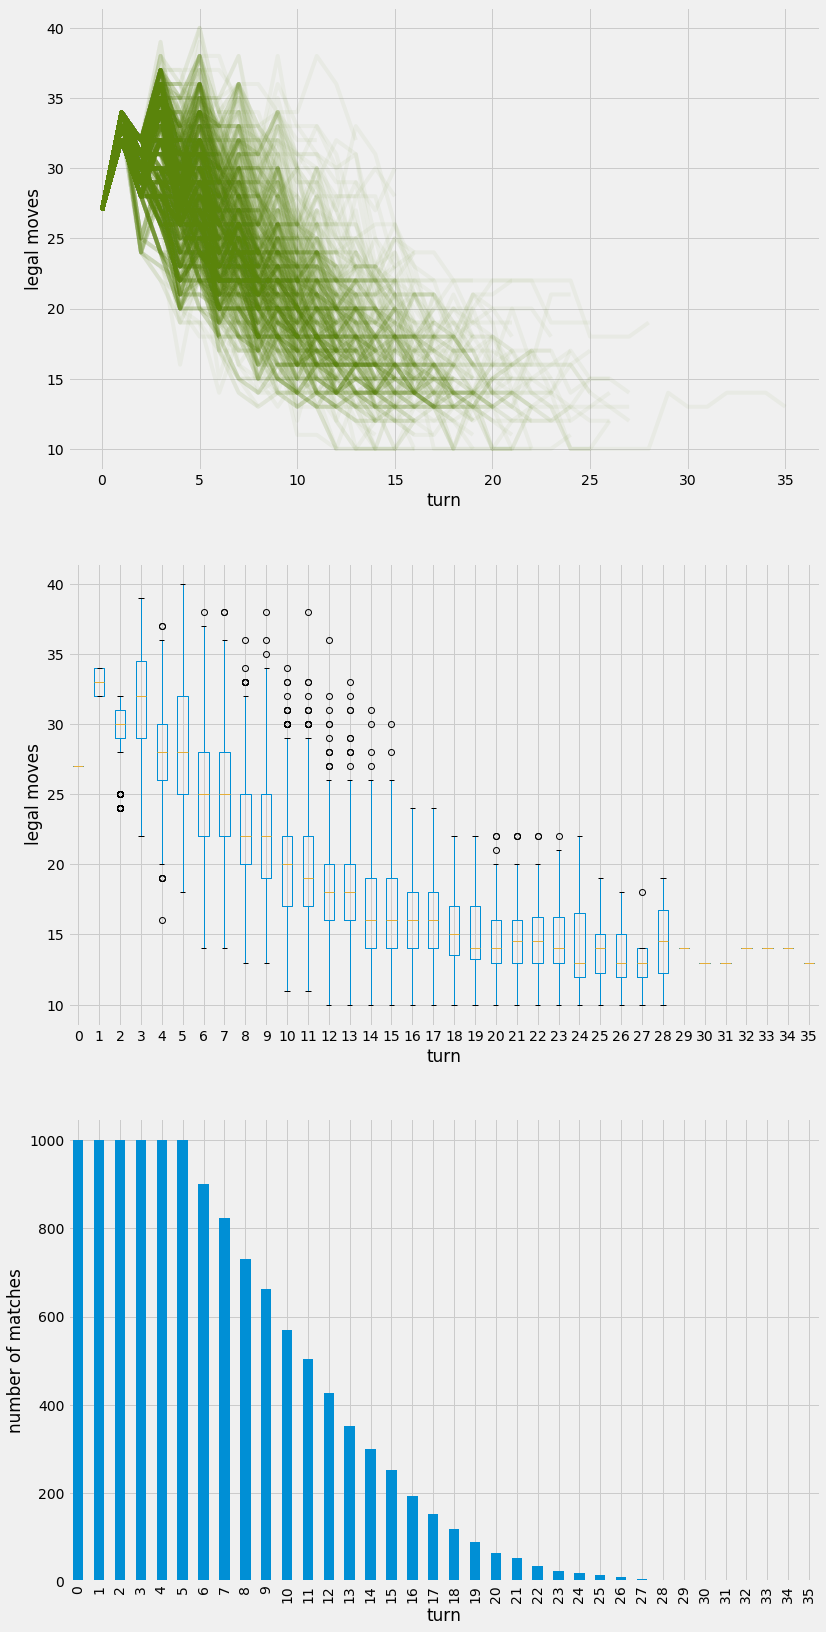

In [43]:
%%time
simulate_matches(1000, partial(negamax_player, 1), partial(negamax_player, 1))

Though strangely, playing against itself the statistics didn't seem to have changed much from the `random_player` simulation...

Notice that the match length decreased a bit now that we got more sophisticated players. Also maybe the first player is capitalizing more...

Let's see if we can figure out what is the best opening in the game. At first in Society Game the players thought 3b2 was the best move but later after some matches it seemed like 1b2 was a better move! Let's investigate this.

In [44]:
def specific_opening(opening_move, player, state):
    if state == INITIAL_GAME_STATE:
        return parse_move(opening_move)(state)
    return player(state)

Another agent wrapper so now we can force the minimax player to start with a specified opening move. There are only 9 possible opening moves (due to symmetry). I'll simulate games with each of them: 1a1, 2a1, 3a1, 1b1, 2b1, 3b1, 1b2, 2b2 and 3b2.

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '1a1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
50.7% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '1a1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    999.000000
mean      11.441441
std        4.336812
min        6.000000
25%        8.000000
50%       10.000000
75%       14.000000
max       31.000000
dtype: float64

Wall time: 28.2 s


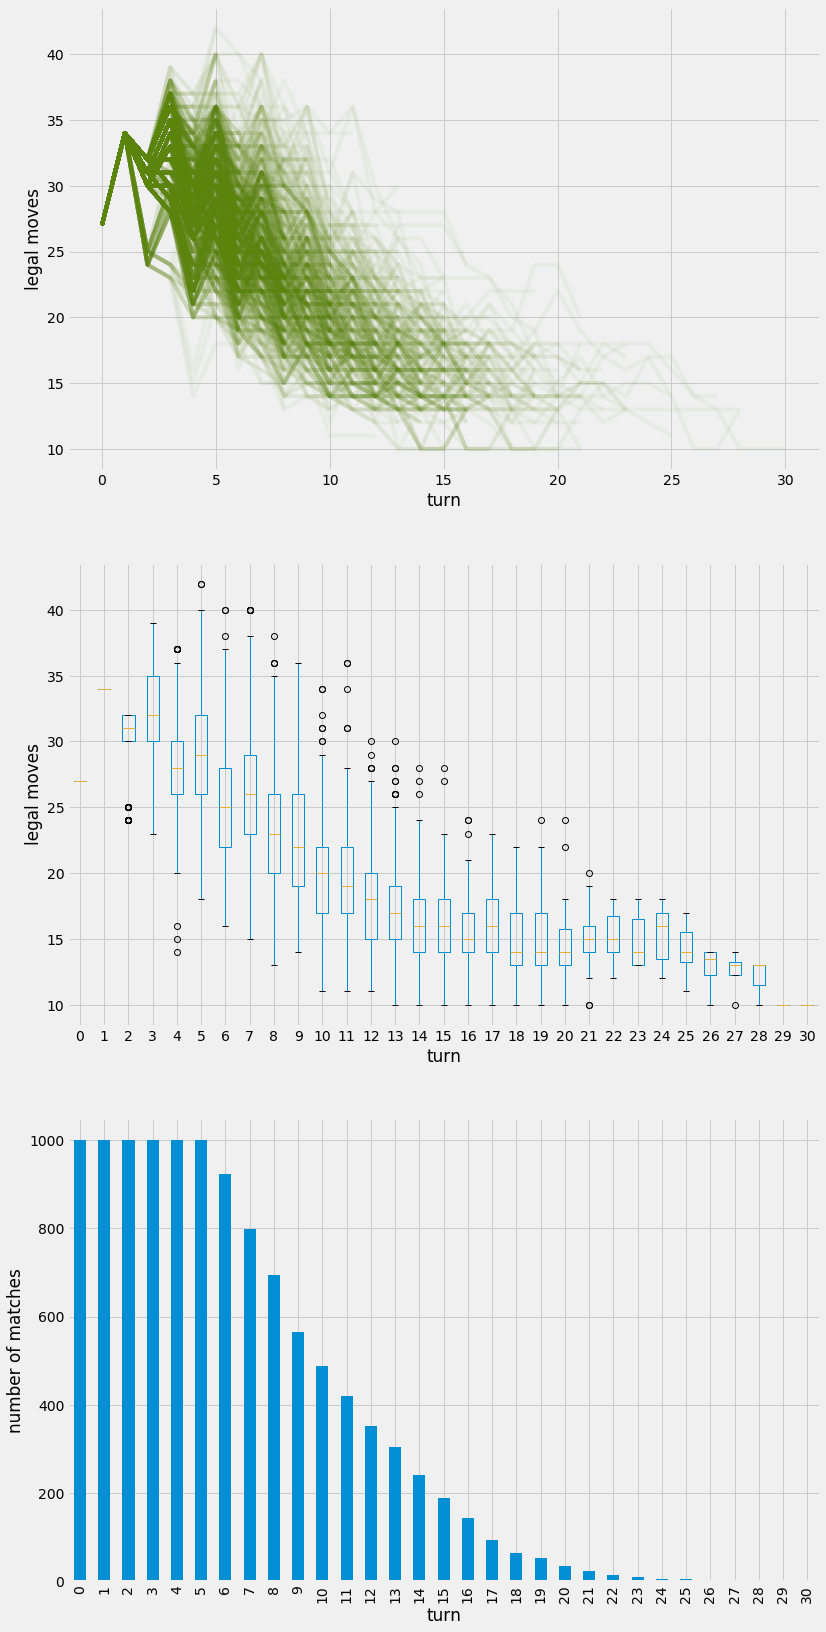

In [64]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '1a1', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '2a1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
52.0% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '2a1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    1000.000000
mean       10.503000
std         4.180606
min         6.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        28.000000
dtype: float64

Wall time: 21.8 s


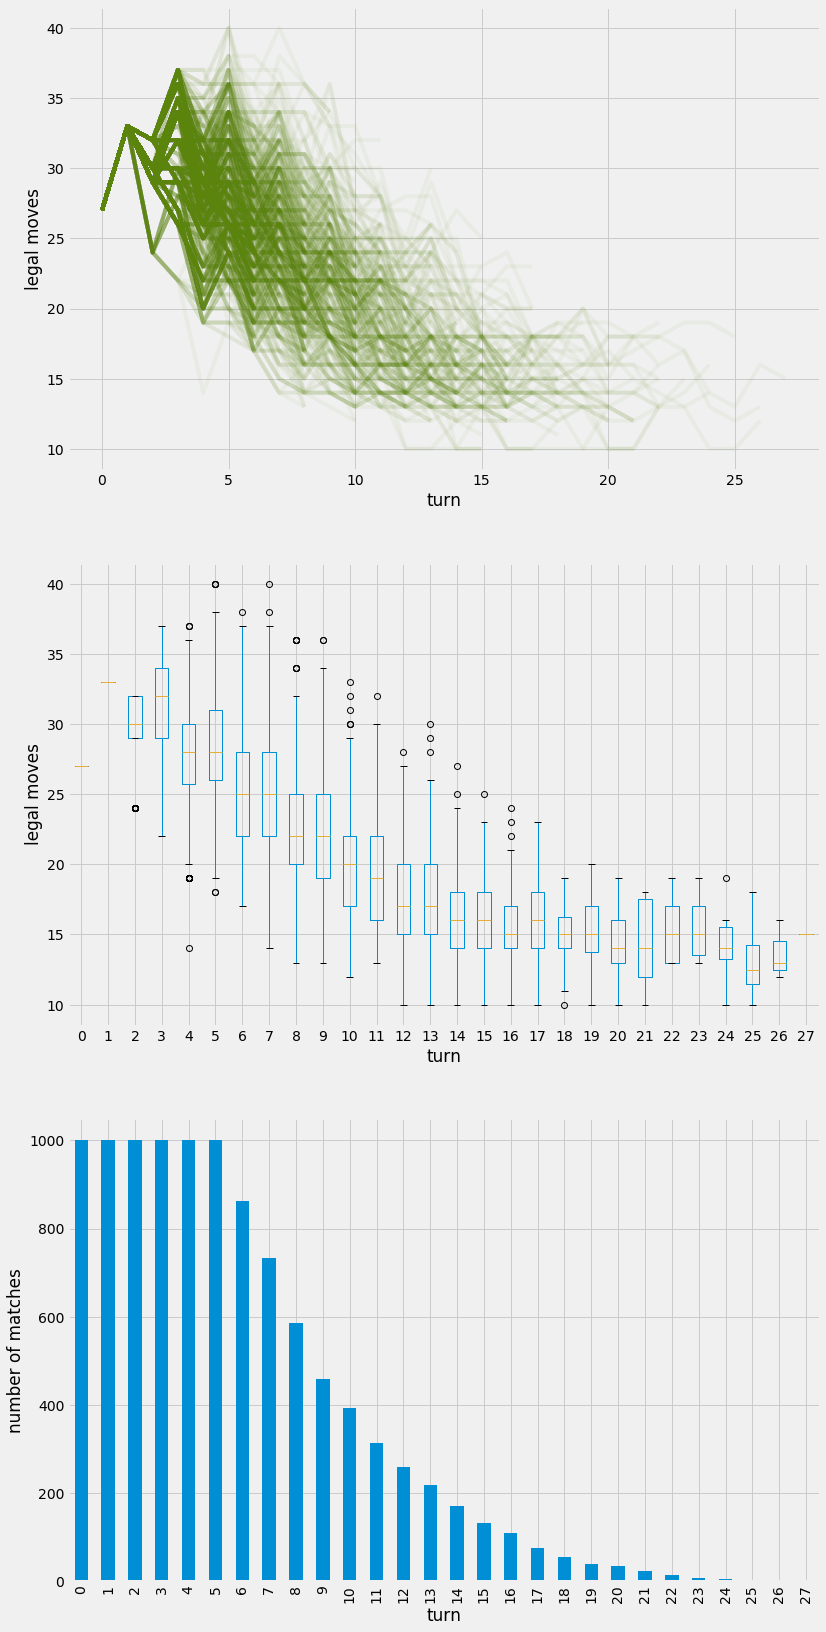

In [65]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '2a1', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '3a1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
54.5% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '3a1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    1000.000000
mean       10.890000
std         4.615539
min         6.000000
25%         8.000000
50%         9.000000
75%        13.000000
max        34.000000
dtype: float64

Wall time: 21.1 s


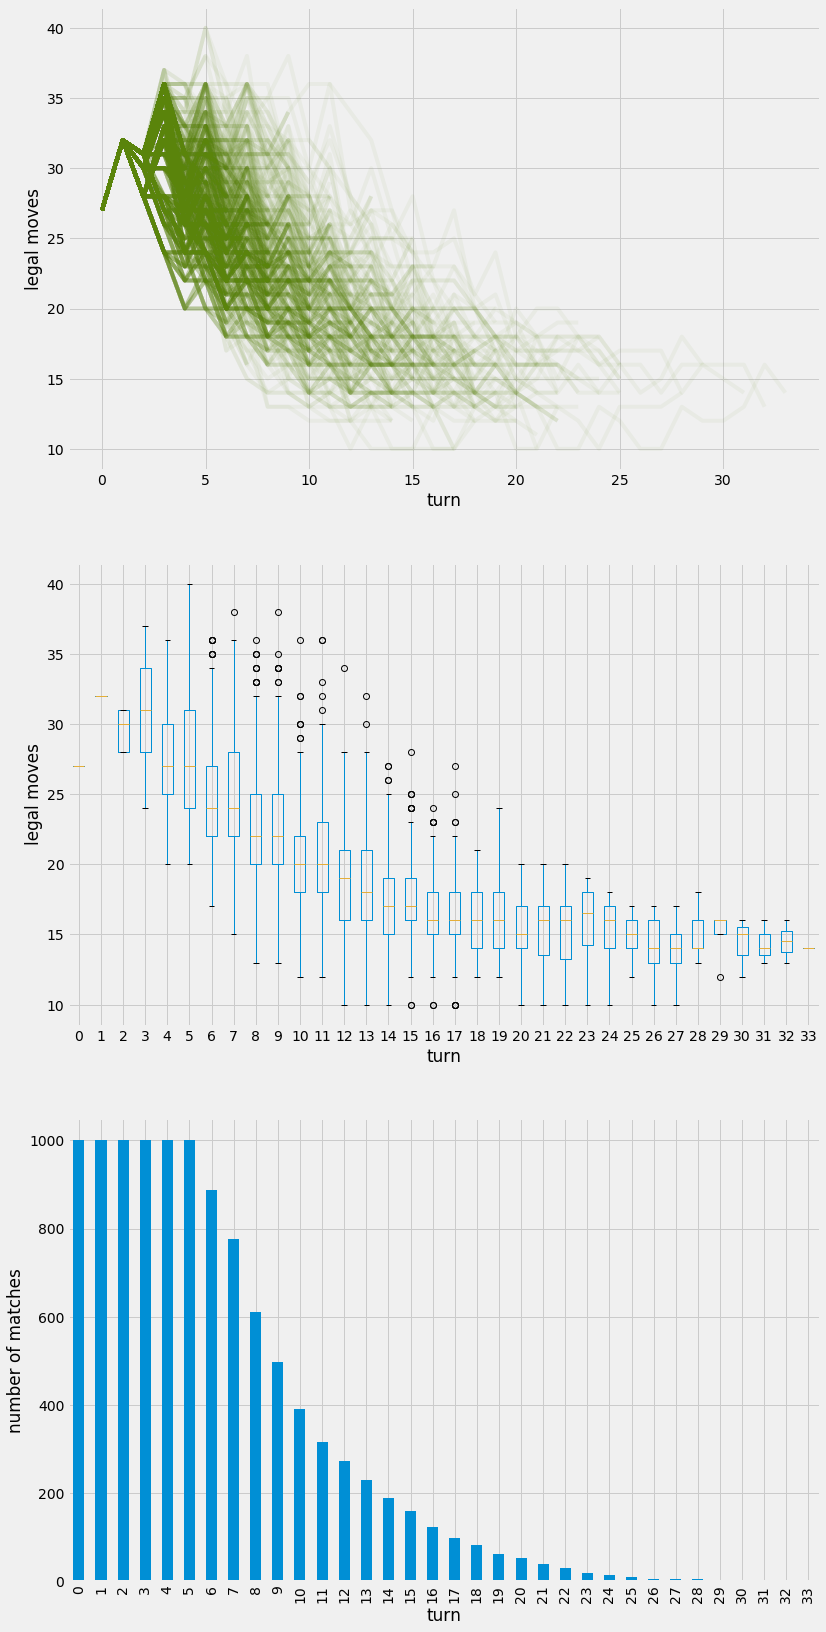

In [66]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '3a1', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '1b1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
51.3% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '1b1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    999.000000
mean      12.264264
std        4.710266
min        6.000000
25%        8.000000
50%       11.000000
75%       15.000000
max       36.000000
dtype: float64

Wall time: 34.2 s


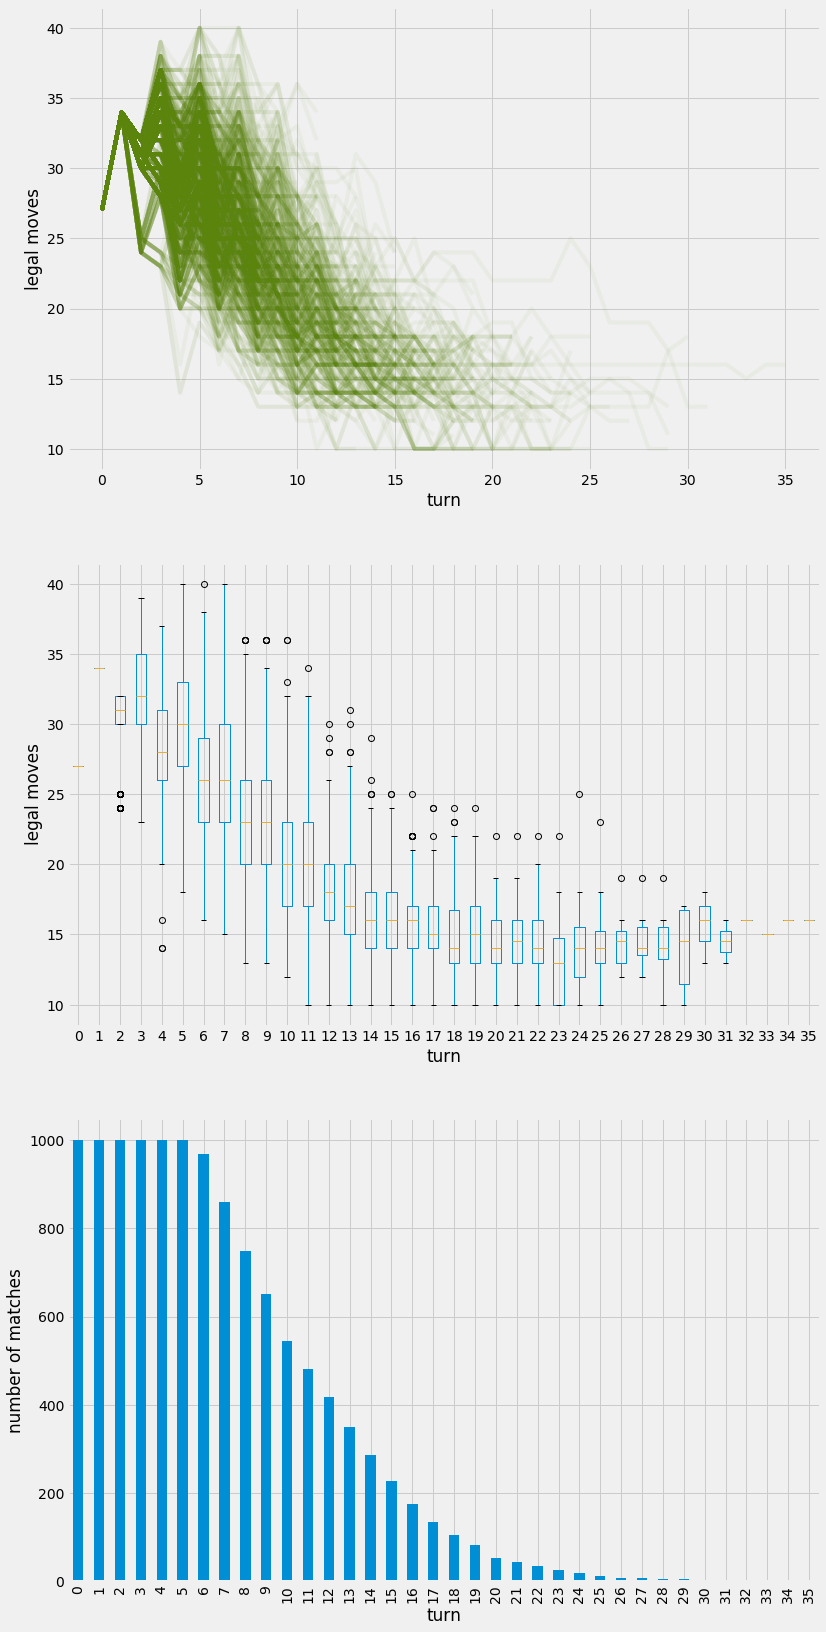

In [67]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '1b1', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '2b1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
53.9% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '2b1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    999.000000
mean      11.388388
std        4.276199
min        6.000000
25%        8.000000
50%       10.000000
75%       14.000000
max       33.000000
dtype: float64

Wall time: 27.1 s


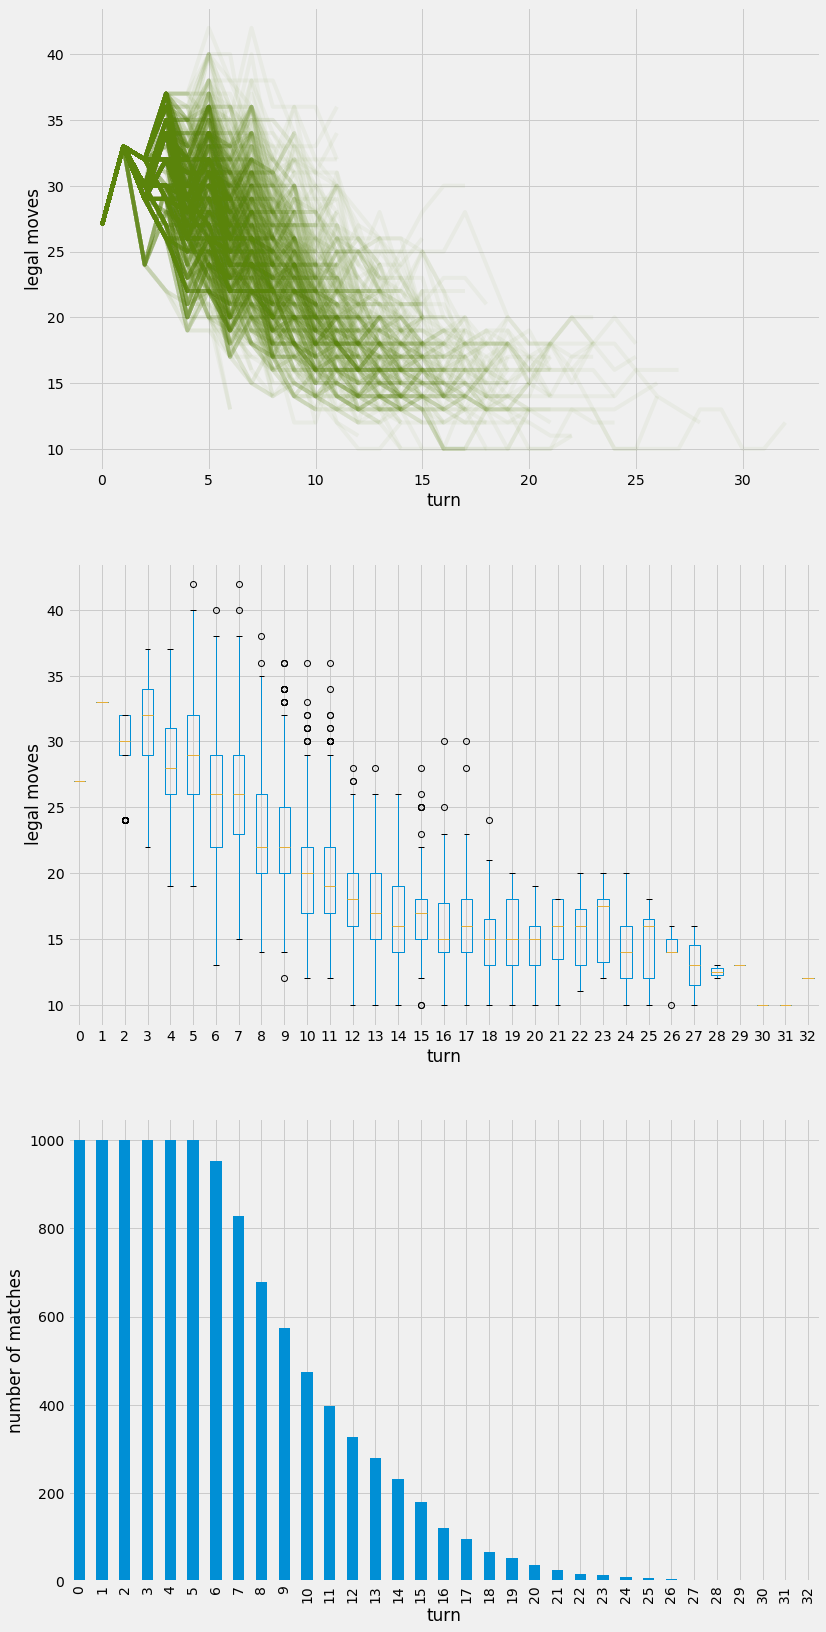

In [68]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '2b1', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '3b1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
54.8% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '3b1', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    1000.000000
mean       10.695000
std         4.418767
min         6.000000
25%         8.000000
50%         9.000000
75%        13.000000
max        33.000000
dtype: float64

Wall time: 20.7 s


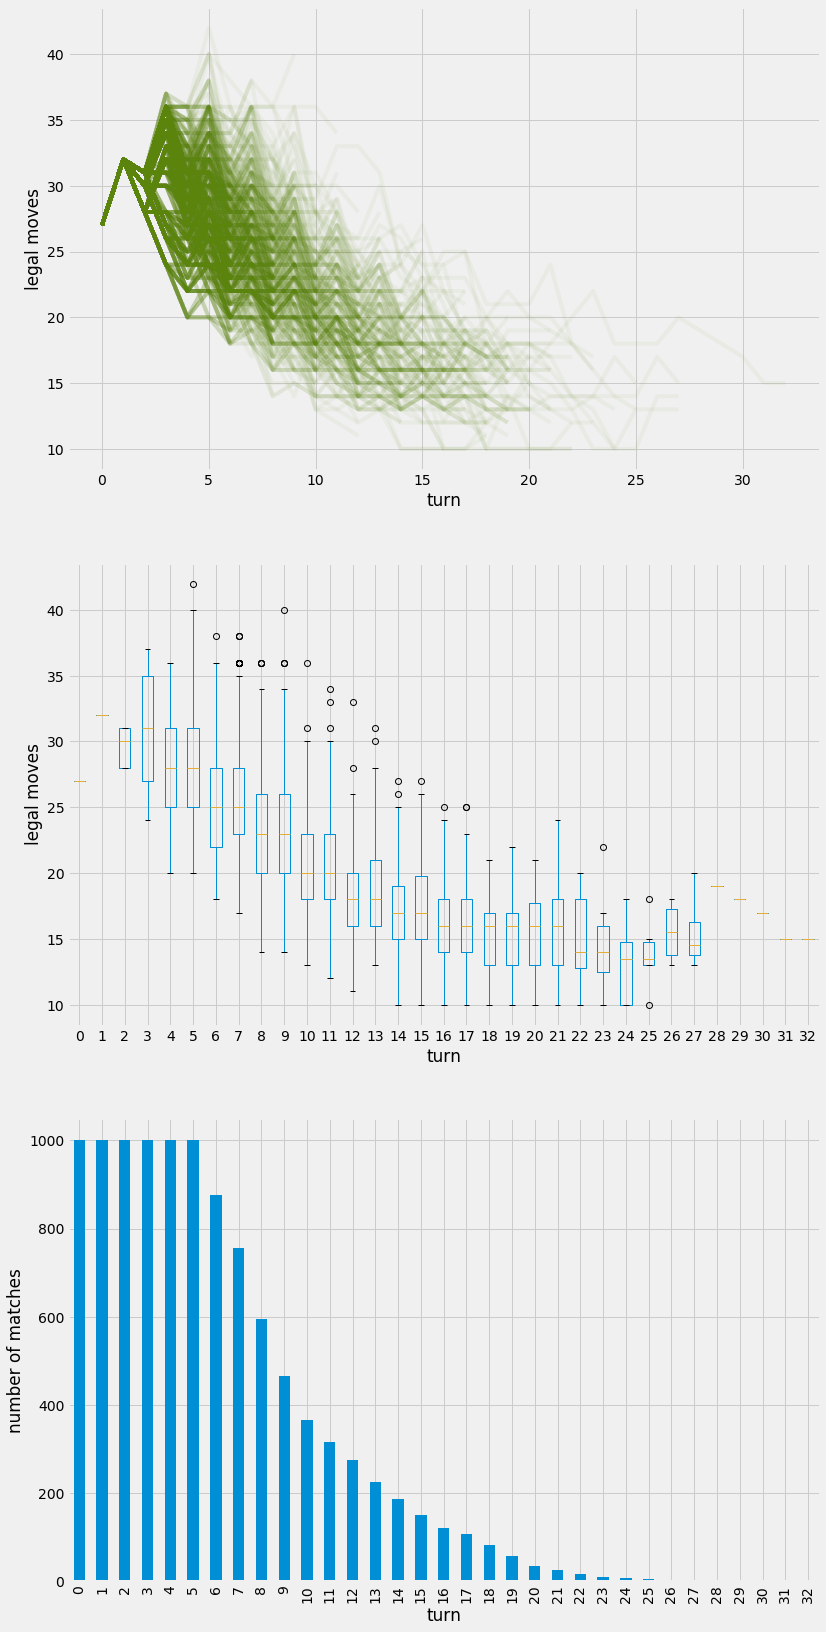

In [69]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '3b1', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '1b2', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
50.6% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '1b2', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    997.000000
mean      11.877633
std        4.554784
min        6.000000
25%        8.000000
50%       11.000000
75%       15.000000
max       39.000000
dtype: float64

Wall time: 28.5 s


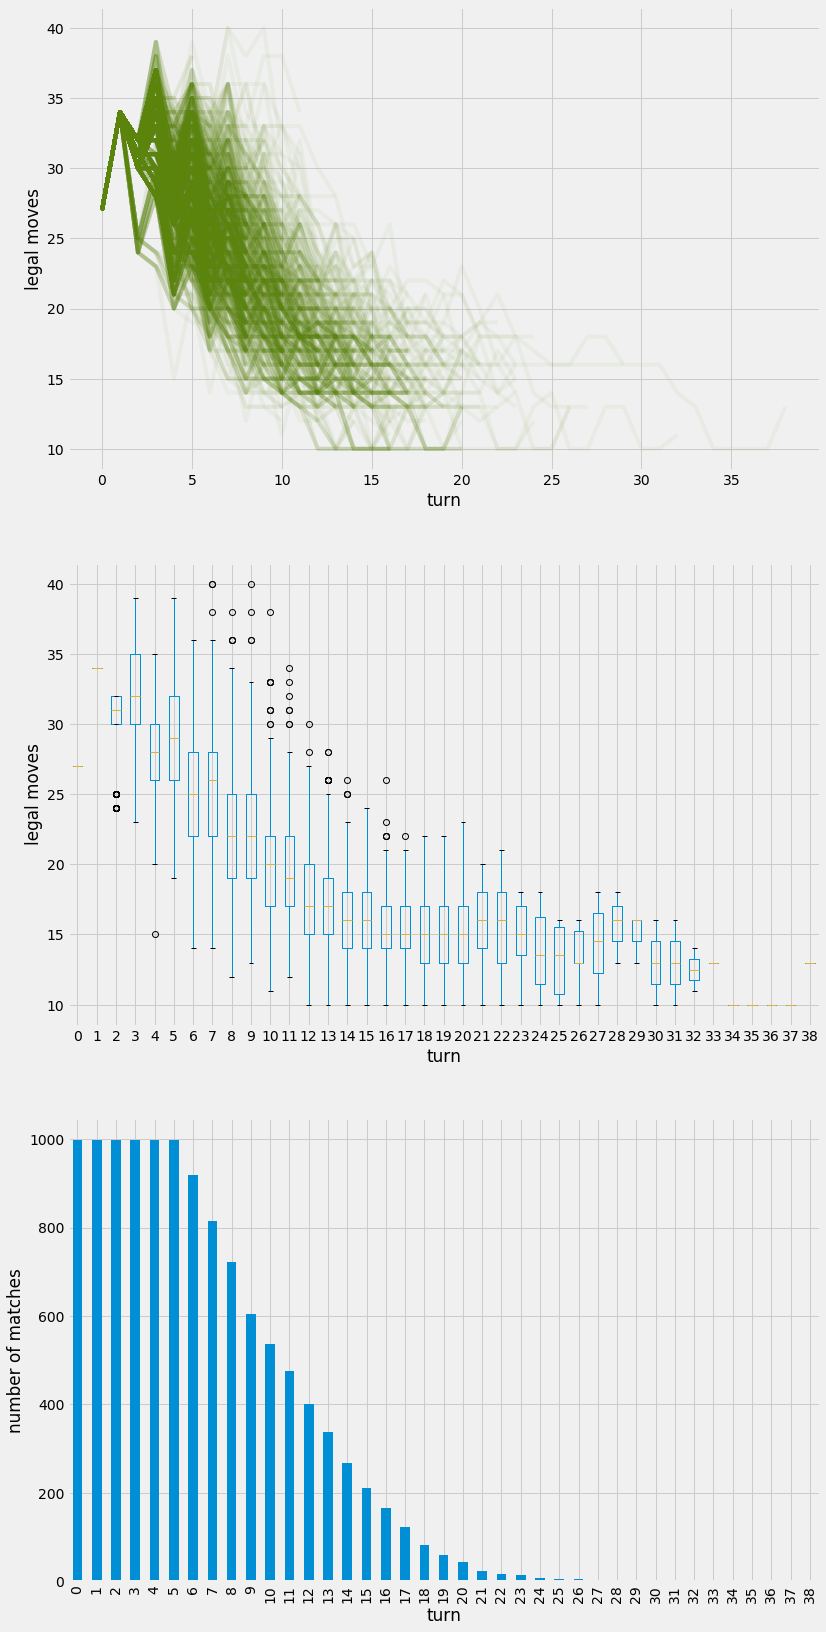

In [70]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '1b2', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '2b2', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1)
45.5% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '2b2', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 1))) victories.

Match length statistics:
count    1000.000000
mean       11.109000
std         4.102188
min         6.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        42.000000
dtype: float64

Wall time: 21.9 s


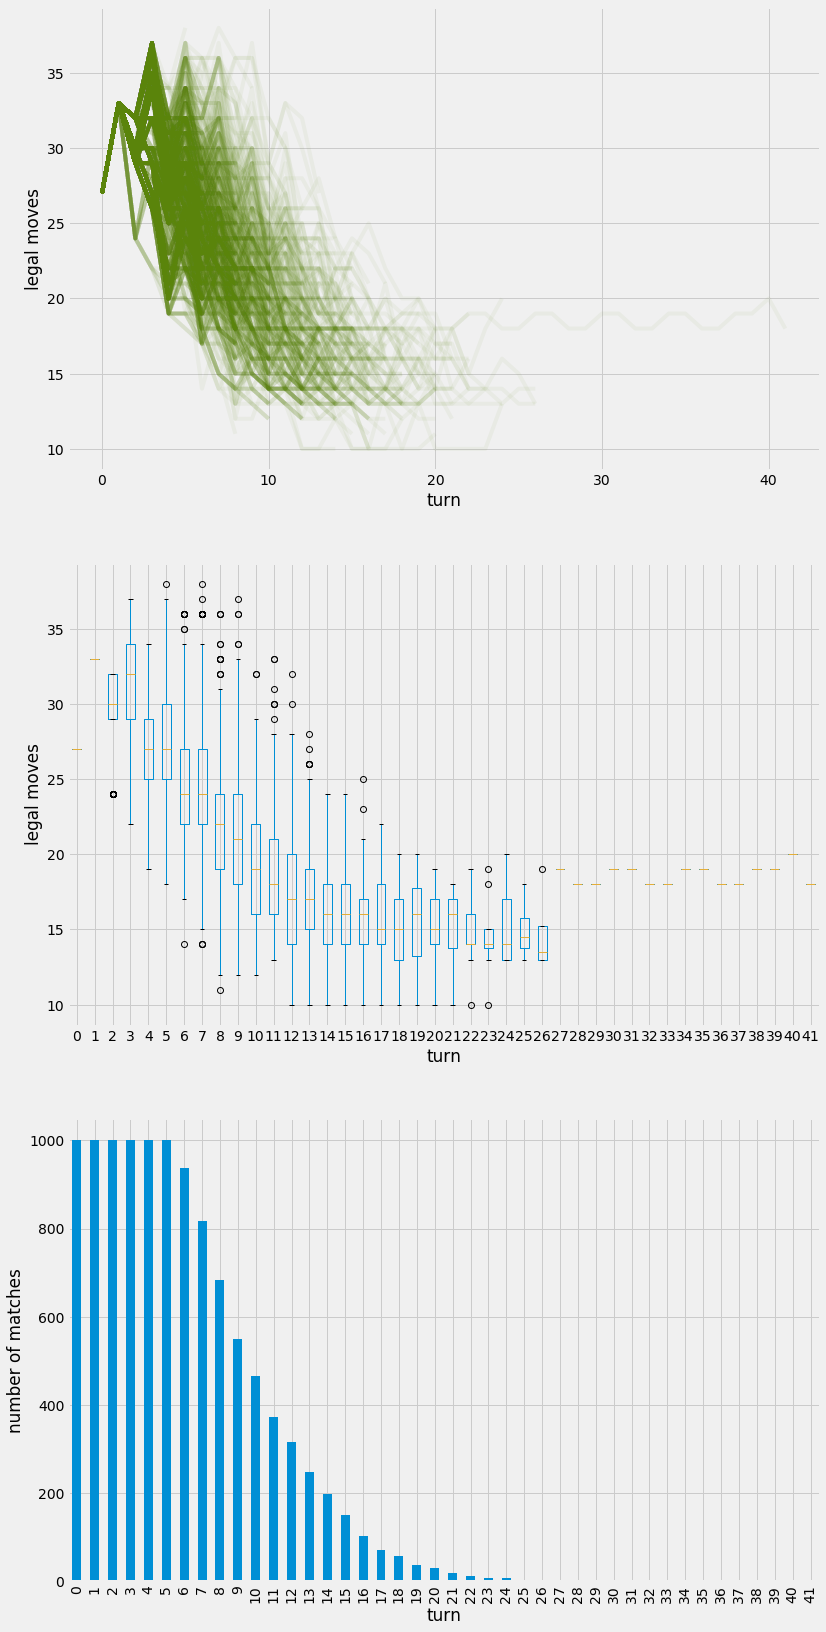

In [71]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '2b2', partial(negamax_player, 1)),
                 partial(negamax_player, 1))

0 matches played...
100 matches played...
200 matches played...
300 matches played...
400 matches played...
500 matches played...
600 matches played...
700 matches played...
800 matches played...
900 matches played...

Simulated 1000 matches of functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '3b2', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 2)) vs functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 2)
65.0% of first player (functools.partial(<function specific_opening at 0x00000079CFFF28C8>, '3b2', functools.partial(<function negamax_player at 0x00000079ACCDAD08>, 2))) victories.

Match length statistics:
count    1000.000000
mean       10.447000
std         3.629651
min         6.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        23.000000
dtype: float64

Wall time: 49.9 s


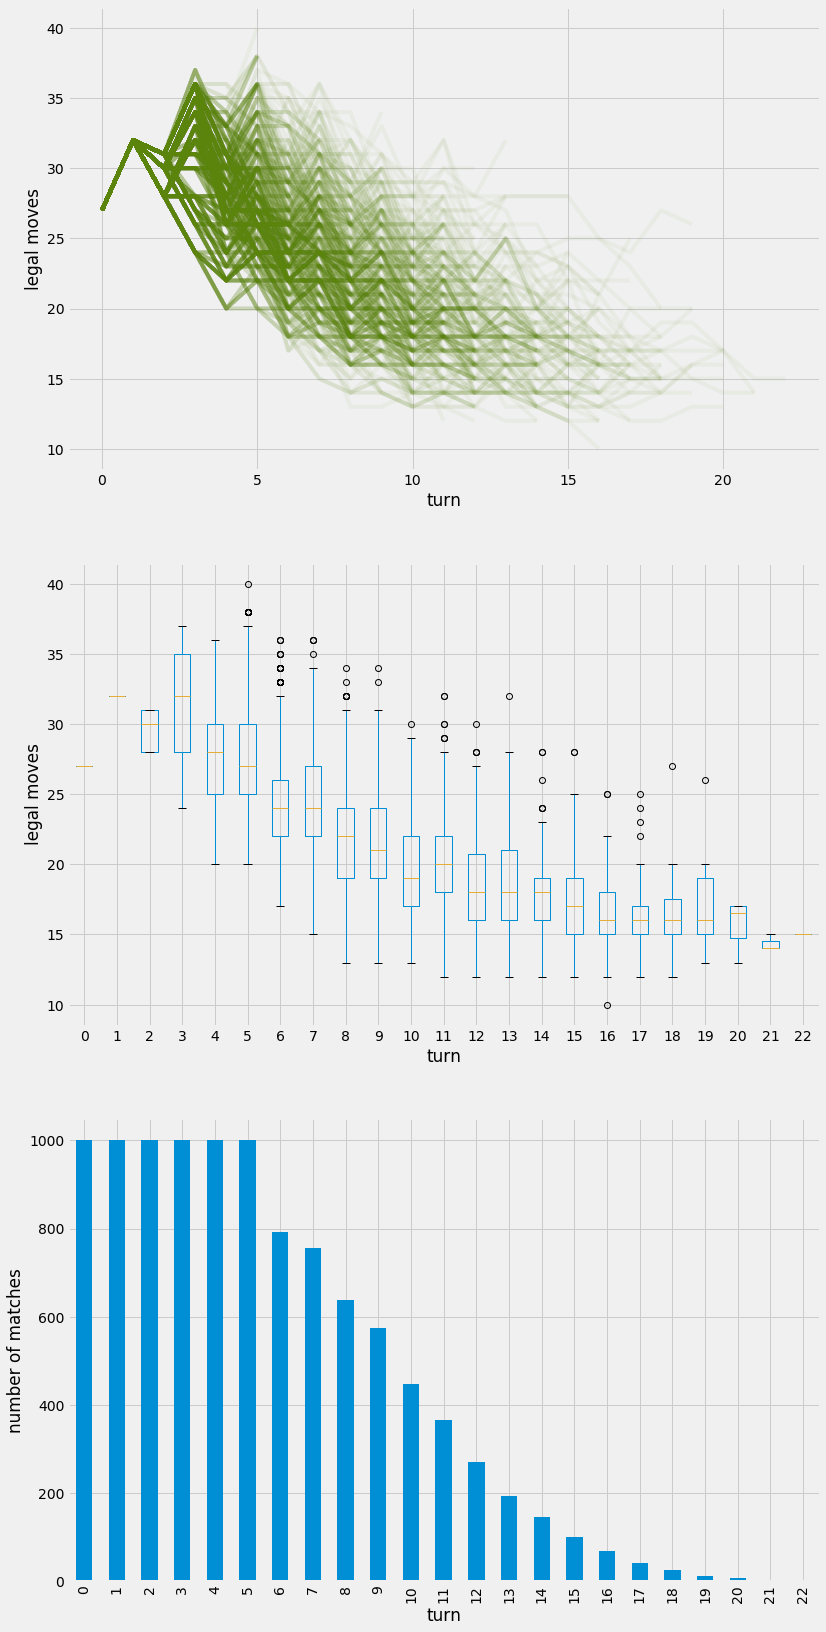

In [72]:
%%time
simulate_matches(1000,
                 partial(specific_opening, '3b2', partial(negamax_player, 2)),
                 partial(negamax_player, 2))

In conclusion... I'm still not sure! I have to actually verify a lot of things but I spent so long on this notebook, you have no idea, so for now I'll say that those simulations show strong evidence that starting out with big pieces are generally better and 3b2 indeed seems to be the best opening move.

2b2 being significantly the worst move was an interesting find.

.
.
.

In [54]:
def test_suite():
    test_is_won()
    test_player_movements()
    test_legal_moves()
    test_number_of_legal_moves_in_a_match()
    test_parse()
    test_negamax()
    
    print('All tests passed!')

test_suite()

All tests passed!
